## Approach

I have taken following approach to solve this problem (alternative approaches are possible)
1. Dependent or outcome variable is Target (values yes or no)
2. Variable both numeric and object, convert object to categories, convert Target to numneric (0 or 1)
3. Treat any unusual values (0 or negative) if necessary and appropriate
4. For continious variables do univariate analysis by dist plots and box plots and describe analysis
5. For categorical variables do univariate analysis by value counts
6. Bivariate - To decide if a continious variable impacts outcome, use correlation heatmap and groupby (against outcome) stats
7. Bivariate - To decide if a categorical variable impacts outcome, use crosstab function against outcome variable. Decide whether to
label encode or one-hot encode based on if there is order. Use label encoding if there is order else one-hot encoding
8. Remove any non-impacting variables from the model. Only those columns will be removed where the data is very unreliable
    or impact is definitely nil. Any others will be retained and it would be left to the model to decide their importance
9. First run the best possible logistic regression model, evaluate its performance 
10. Then run a simple decision tree model and evaluate its perfomance
11. Then run ensemble models (random forest, adaboost, bagging, gradient boost) and record results in a dataframe
12. Compare accurancy, recall and precision of all these models and select the best
13. From Business perspective Recall is the most important criterion here as the bank would like to maximize the hit rate. Final 
model will be selected based on it
14. Generate final confusion matrix and provide commentary

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system
import sys
# This is not the complete set, more will be imported as and when necessary

## Load and review data

In [2]:
pdata = pd.read_csv("bank-full.csv")

In [3]:
pdata.shape # Check number of columns and rows in data frame

(45211, 17)

In [4]:
pdata.head() # To check first 5 rows of data set

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
pdata.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [7]:
#I shall comment on this after univariate plots

In [8]:
#check null values
pdata.isnull().sum()


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [9]:
#output shows there are no null values. 

In [10]:
pdata.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
Target          2
dtype: int64

In [11]:
for feature in pdata.columns: # Loop through all columns in the dataframe
    if pdata[feature].dtype == 'object': # Only apply for columns with categorical strings
        pdata[feature] = pd.Categorical(pdata[feature])
pdata.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Use value counts for univariate analysis of categorical variables

In [12]:
for i in ["job","marital", "education", "default","housing", "loan", "contact", "month", "poutcome","Target"]:   # checking value counts of all object type columns
    print(pdata[i].value_counts())
   

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
n

In [13]:
for i in ["job","marital", "education", "default","housing", "loan", "contact", "month", "poutcome","Target"]:   # checking value counts of all object type columns
    print(pdata[i].value_counts(normalize=True))

blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: job, dtype: float64
married     0.601933
single      0.282896
divorced    0.115171
Name: marital, dtype: float64
secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: education, dtype: float64
no     0.981973
yes    0.018027
Name: default, dtype: float64
yes    0.555838
no     0.444162
Name: housing, dtype: float64
no     0.839774
yes    0.160226
Name: loan, dtype: float64
cellular     0.647741
unknown      0.287983
telephone    0.064276
Name: contact, dtype: float64
may    0.304483
jul    0.152507
aug    0.138174
jun    0.118135
nov    0.087810
apr    0.064851
feb    0.058592
jan    0.031032
oct    0.016323
sep    0.012807
mar    0.0

Observations:
    Poutcome -  this has 81% of values as 'unknown'. This is example of bad data. This should not be fed to the model
    bwcause 'unknown' is not a true category value i.e. we cannot say 60% of cases with poutcome as Unknown would subscibe to
    term deposit. This column will introdice wrong bias in the model and hence should be dropped
    
    Contact - 28% unknown which is another example of bad data. However based on crosstab analysis this column may show legitimate 
    influence on the model. The mode is Cellular (64%) so Unknown here might have to be tolerated
    
    Education - Only 4% Unknown, which is not uncommon. These should be replaced with mode if appropriate and fed to the model
    
    Other columns just nominal categorical columns

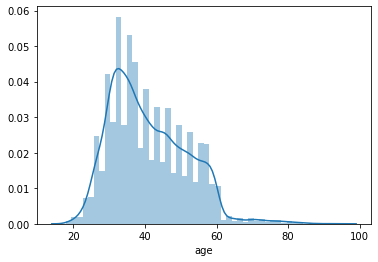

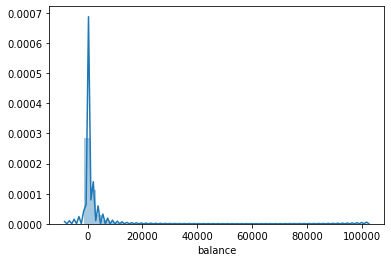

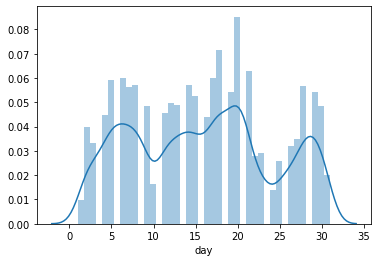

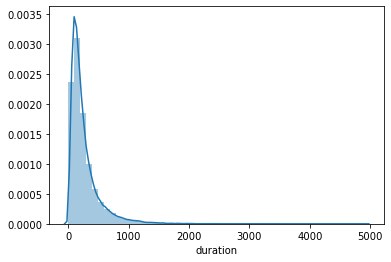

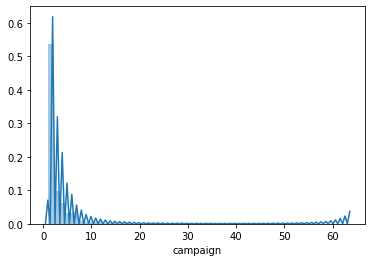

C:\Users\ddaml\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


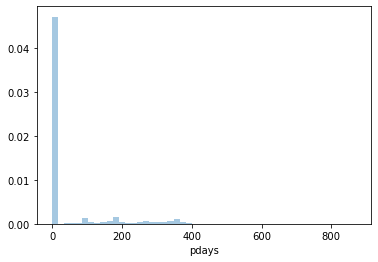

C:\Users\ddaml\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


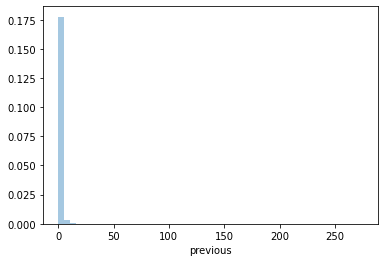

In [14]:


# distplot for continous columns
for i in ['age','balance','day','duration', 'campaign', 'pdays', 'previous']:
    sns.distplot(pdata[i])
    plt.show()

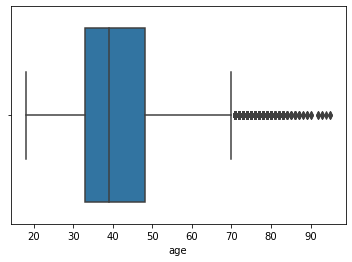

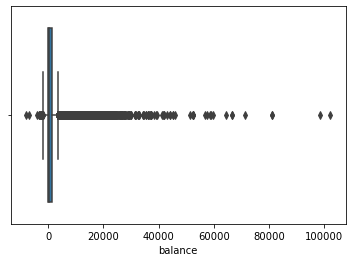

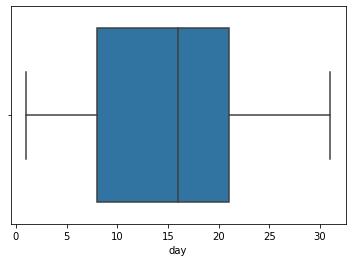

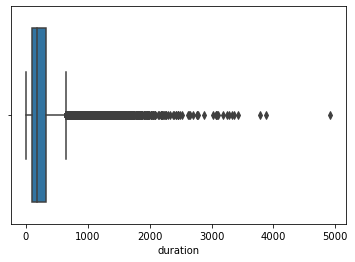

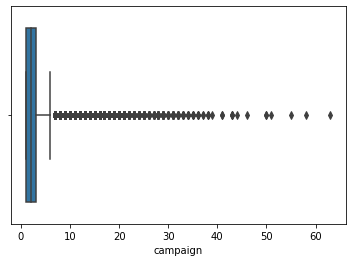

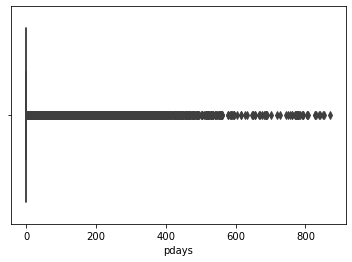

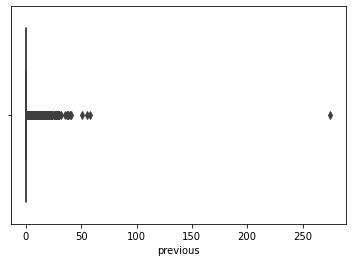

In [15]:
for i in ['age','balance','day','duration', 'campaign', 'pdays', 'previous']:
    sns.boxplot(pdata[i])
    plt.show()

The plots and the info from Describe command shows us that only Age and Day show Normal distribution (mean closer to median).
All others show heavy postive skew (median much leass than mean) and are heavily infleunced by outliers on right side.

Balance has got both negative and positive values with the positive outliers stretching the scale. The negative balance values
are valid as they indicate overdraft

Another notable column is pdays. We shall examine pdays in more detail below

In [16]:
#althoguh pdays is numeric, it is is so much skewed (median as well as 3rd quartile is -1 but mean is 40) that it is 
#roughly divided in 2 categories, pdays = -1 and pdays > -1. Let us split the dataset along these 
#values and examine if target is siginificantly affected by pdays > -1
pdata[pdata["pdays"] == -1].count()

age          36954
job          36954
marital      36954
education    36954
default      36954
balance      36954
housing      36954
loan         36954
contact      36954
day          36954
month        36954
duration     36954
campaign     36954
pdays        36954
previous     36954
poutcome     36954
Target       36954
dtype: int64

In [17]:
pdataA = pdata.loc[(pdata["pdays"] == -1)]
pdataB = pdata.loc[(pdata["pdays"] > -1)]                    

In [18]:
pdataA.groupby(["Target"]).count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
Target,,,,,,,,,,,,,,,,
no,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570,33570
yes,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384,3384


In [19]:
pdataB.groupby(["Target"]).count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
Target,,,,,,,,,,,,,,,,
no,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352
yes,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905


In [20]:
#36954 rows out of 45211 have pdays = -1, this means the customer was not contacted, this is why both the median and 75% quartile 
#is -1, the mean is skewed by some outliers. 9% records with -1 have Target as Yes whereas 23% of records with >-1 have target as
#Yes so maybe there is an impact.


## Identify Correlation in data 

In [21]:
#Convert Traget to numeric so that it is included in corr heatmap
pdata['Target'] = pdata['Target'].map({'no':0,'yes':1})
pdata['Target'] = pdata['Target'].astype(int)
pdata['Target']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: Target, Length: 45211, dtype: int32

In [22]:
#For bivariate analylis we can check the correlation between independent variables and also between independent variables and 
#outcome variable
pdata.corr() # It will show correlation matrix 

,age,balance,day,duration,campaign,pdays,previous,Target
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236
Target,0.025155,0.052838,-0.028348,0.394521,-0.073172,0.103621,0.093236,1.000000


In [23]:
# However we want to see correlation in graphical representation so below is function for that
def plot_corr(df, size=15):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

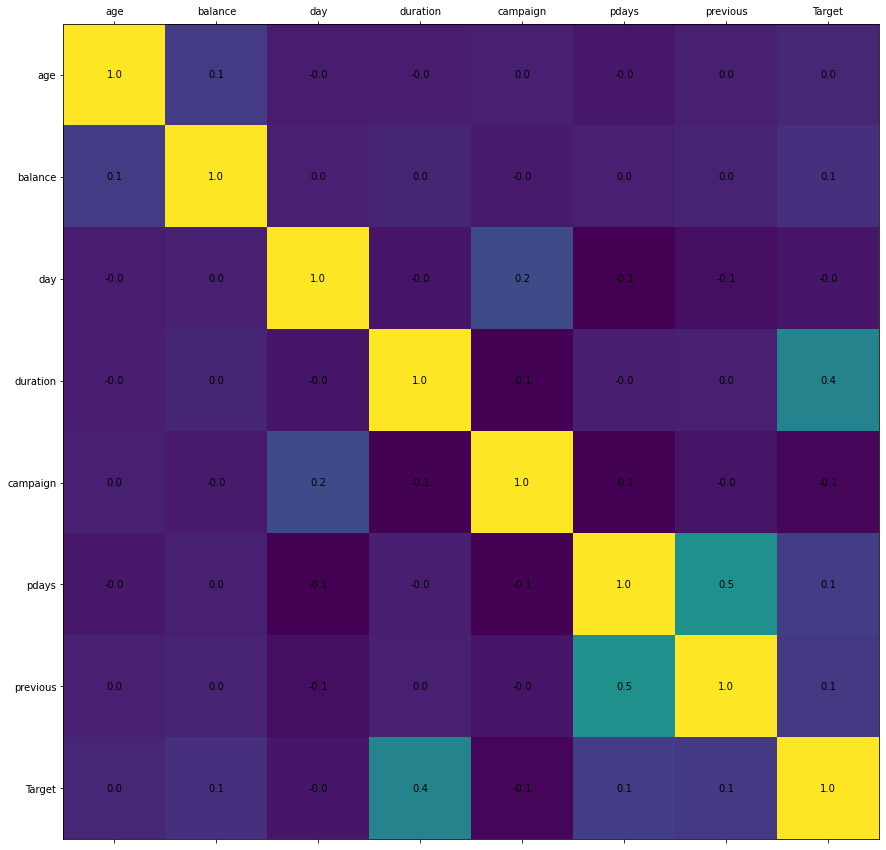

In [24]:
plot_corr(pdata)

In above plot yellow colour represents maximum correlation and blue colour represents minimum correlation. We can see tno significant coorelation with Target or within the features

After groupby and crosstab analysis, which we must consider in addition to corr,  we can cofirm which to drop

In [25]:
#use output of this for decison on continious variables
pdata.groupby(["Target"]).mean()

,age,balance,day,duration,campaign,pdays,previous
Target,,,,,,,
0,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
1,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


In [26]:
# For Age and Day, there is hardly any difference in the mean. However Age data is good and can be important
#from business perspective so will ratain Age but drop Day

In [27]:
#use output of this for decison on continious variables
pdata.groupby(["Target"]).median()

,age,balance,day,duration,campaign,pdays,previous
Target,,,,,,,
0,39,417,16,164,2,-1,0
1,38,733,15,426,2,-1,0


In [28]:
# For Age and Day, there is hardly any difference in the median. However Age data is good and can be important
#from business perspective so will ratain Age but drop Day

In [29]:
#Now do crosstab analysis for categorical variables. We shall do it both ways (to understand how a category is split across Target
# and how Target is split across categories) to have better understanding and will include
#both percentages and actual numbers. There 5289 actual Target values in the dataset

In [30]:
df = pd.crosstab(pdata['job'],pdata['Target'],normalize='index')
sorted_df = df.sort_values(by=1)
print(sorted_df)

Target                0         1
job                              
blue-collar    0.927250  0.072750
entrepreneur   0.917283  0.082717
housemaid      0.912097  0.087903
services       0.911170  0.088830
technician     0.889430  0.110570
unknown        0.881944  0.118056
self-employed  0.881571  0.118429
admin.         0.877973  0.122027
management     0.862444  0.137556
unemployed     0.844973  0.155027
retired        0.772085  0.227915
student        0.713220  0.286780


In [31]:
pd.crosstab(pdata['Target'],pdata['job'])

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
Target,,,,,,,,,,,,
0,4540,9024,1364,1131,8157,1748,1392,3785,669,6757,1101,254
1,631,708,123,109,1301,516,187,369,269,840,202,34


In [32]:
#The above shows that there is no real order as such we shall one hot encode Job

In [33]:
pd.crosstab(pdata['marital'],pdata['Target'],normalize='index')

Target,0,1
marital,,
divorced,0.880545,0.119455
married,0.898765,0.101235
single,0.850508,0.149492


In [34]:
pd.crosstab(pdata['Target'],pdata['marital'])

marital,divorced,married,single
Target,,,
0,4585,24459,10878
1,622,2755,1912


In [35]:
#we cannot determine order here so we shall one bhot encode 'marital'

In [36]:
pd.crosstab(pdata['education'],pdata['Target'],normalize='index')

Target,0,1
education,,
primary,0.913735,0.086265
secondary,0.894406,0.105594
tertiary,0.849936,0.150064
unknown,0.864297,0.135703


In [37]:
pd.crosstab(pdata['Target'],pdata['education'])

education,primary,secondary,tertiary,unknown
Target,,,,
0,6260,20752,11305,1605
1,591,2450,1996,252


In [38]:
# We can see some order here as the percentage of educated in each bucket are increasingly taking term deposit from primary
#to tertiary (8% for primary, 10% for secondary, 15% for tertiary). Prportion of Unknown is very small (around 4%) so we can
#replace it with Mode of the column, which is 'secondary'. We can then label encodew this category

In [39]:
pd.crosstab(pdata['default'],pdata['Target'],normalize='index')

Target,0,1
default,,
no,0.882039,0.117961
yes,0.936196,0.063804


In [40]:
pd.crosstab(pdata['Target'],pdata['default'])

default,no,yes
Target,,
0,39159,763
1,5237,52


In [41]:
#There is a clear correalton in taking on term deposit if there is no default, so we shall label encode this 
#as Yes = 0 and No = 1

In [42]:
pd.crosstab(pdata['housing'],pdata['Target'],normalize='index')

Target,0,1
housing,,
no,0.832976,0.167024
yes,0.923000,0.077000


In [43]:
pd.crosstab(pdata['Target'],pdata['housing'])

housing,no,yes
Target,,
0,16727,23195
1,3354,1935


In [44]:
#There is a clear correalton in taking on term deposit if there is no housing, so we shall label encode this 
#as Yes = 0 and No = 1

In [45]:
pd.crosstab(pdata['loan'],pdata['Target'],normalize='index')

Target,0,1
loan,,
no,0.873443,0.126557
yes,0.933186,0.066814


In [46]:
pd.crosstab(pdata['Target'],pdata['loan'])

loan,no,yes
Target,,
0,33162,6760
1,4805,484


In [47]:
#There is a clear correalton in taking on term deposit if there is no loan, so we shall label encode this 
#as Yes = 0 and No = 1

In [48]:
pd.crosstab(pdata['contact'],pdata['Target'],normalize='index')

Target,0,1
contact,,
cellular,0.850811,0.149189
telephone,0.865795,0.134205
unknown,0.959293,0.040707


In [49]:
pd.crosstab(pdata['Target'],pdata['contact'])

contact,cellular,telephone,unknown
Target,,,
0,24916,2516,12490
1,4369,390,530


In [50]:
#There is some order flowing from Unknown to Cellular, although Unknown makes it bad data. Unfortunaty we cannt treat it
#satisfactorily so we shall leave it there. We shall label encode this as unknown=0, telephone=1, cellular = 2

In [51]:
pd.crosstab(pdata['month'],pdata['Target'],normalize='index')

Target,0,1
month,,
apr,0.803206,0.196794
aug,0.889867,0.110133
dec,0.532710,0.467290
feb,0.833522,0.166478
jan,0.898788,0.101212
jul,0.909065,0.090935
jun,0.897772,0.102228
mar,0.480084,0.519916
may,0.932805,0.067195


In [52]:
pd.crosstab(pdata['Target'],pdata['month'],normalize='index')

month,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
Target,,,,,,,,,,,,
0,0.058990,0.139247,0.002856,0.055308,0.031587,0.157006,0.120109,0.005736,0.321652,0.089349,0.010395,0.007765
1,0.109094,0.130081,0.018907,0.083381,0.026848,0.118548,0.103233,0.046890,0.174891,0.076196,0.061070,0.050860


In [53]:
pd.crosstab(pdata['Target'],pdata['month'])

month,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
Target,,,,,,,,,,,,
0,2355,5559,114,2208,1261,6268,4795,229,12841,3567,415,310
1,577,688,100,441,142,627,546,248,925,403,323,269


In [54]:
#Month of May shows highest take up but there is no real order and we cannot number the months from 1 to 12 so 
#we shall use one hot encoding

In [55]:
pd.crosstab(pdata['poutcome'],pdata['Target'],normalize='index')

Target,0,1
poutcome,,
failure,0.873903,0.126097
other,0.833152,0.166848
success,0.352747,0.647253
unknown,0.908385,0.091615


In [56]:
pd.crosstab(pdata['Target'],pdata['poutcome'])

poutcome,failure,other,success,unknown
Target,,,,
0,4283,1533,533,33573
1,618,307,978,3386


In [57]:
#We have already discussed poutcome, it should be dropped

## Calculate ratio of True/False from outcome variable 

In [58]:
n_true = len(pdata.loc[pdata['Target'] == True])
n_false = len(pdata.loc[pdata['Target'] == False])
print("Number of true cases: {0} ({1:2.2f}%)".format(n_true, (n_true / (n_true + n_false)) * 100 ))
print("Number of false cases: {0} ({1:2.2f}%)".format(n_false, (n_false / (n_true + n_false)) * 100))

Number of true cases: 5289 (11.70%)
Number of false cases: 39922 (88.30%)


So we have 11.70% people in current data set who have subscribed to term deposit. 



# Data Preparation

### Check hidden missing values 

We checked missing values earlier but haven't got any. We have got some negatives but they are valid.

In [59]:
#drop 'day' and 'potcome' as explained earlier. Create seperate dataframe for modelling
pdata_model = pdata.drop(["day", "poutcome"], axis = 1)
pdata_model.head()


,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,0


In [60]:
#change education values "unknown" to mode of education column, which is "secondary"
pdata_model["education"] = pdata_model["education"].replace("unknown", "secondary")
pdata_model["education"].value_counts()

secondary    25059
tertiary     13301
primary       6851
Name: education, dtype: int64

In [61]:
#Label encode and one-hot encode as explained earlier
replaceStruct = {
                
                 "education":     {"primary": 1, "secondary": 2 ,"tertiary": 3 },
                "default": {"yes": 0, "no": 1}, "housing": {"yes": 0, "no": 1}, "loan": {"yes": 0, "no": 1},
                "contact": {"unknown": 0, "telephone": 1, "cellular": 2}
                 }
oneHotCols=["job","marital", "month" ]

In [62]:
pdata_model = pdata_model.replace(replaceStruct)
pdata_model = pd.get_dummies(pdata_model, columns=oneHotCols)
pdata_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                45211 non-null  int64
 1   education          45211 non-null  int64
 2   default            45211 non-null  int64
 3   balance            45211 non-null  int64
 4   housing            45211 non-null  int64
 5   loan               45211 non-null  int64
 6   contact            45211 non-null  int64
 7   duration           45211 non-null  int64
 8   campaign           45211 non-null  int64
 9   pdays              45211 non-null  int64
 10  previous           45211 non-null  int64
 11  Target             45211 non-null  int32
 12  job_admin.         45211 non-null  uint8
 13  job_blue-collar    45211 non-null  uint8
 14  job_entrepreneur   45211 non-null  uint8
 15  job_housemaid      45211 non-null  uint8
 16  job_management     45211 non-null  uint8
 17  job_retired 

## Spliting the data 
We will use 70% of data for training and 30% for testing.

In [63]:
from sklearn.model_selection import train_test_split

X = pdata_model.drop('Target',axis=1)     # Predictor feature columns 
Y = pdata_model['Target']   # Predicted class (1=True, 0=False) 

#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
# 1 is just any random seed number
features = [col for col in pdata_model.columns if col != 'Target']

x_train, x_test, y_train, y_test = train_test_split(pdata_model[features], pdata_model['Target'], test_size=.3, random_state=22)
x_train.shape, x_test.shape

x_train.head()

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
22411,36,3,1,0,1,1,2,136,2,-1,...,0,0,0,0,0,0,0,0,0,0
28589,45,1,1,-407,0,0,2,503,2,224,...,0,0,1,0,0,0,0,0,0,0
24461,41,2,1,112,0,1,2,1081,1,131,...,0,0,0,0,0,0,0,1,0,0
32766,51,2,1,528,0,1,2,324,3,-1,...,0,0,0,0,0,0,0,0,0,0
21336,48,1,1,199,1,1,1,29,2,-1,...,0,0,0,0,0,0,0,0,0,0


Lets check split of data

In [64]:
print("{0:0.2f}% data is in training set".format((len(x_train)/len(pdata_model.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(pdata_model.index)) * 100))

70.00% data is in training set
30.00% data is in test set


Now lets check True/False ratio in split data 

In [65]:
print("Original Term Deposit True Values    : {0} ({1:0.2f}%)".format(len(pdata_model.loc[pdata_model['Target'] == 1]), (len(pdata_model.loc[pdata_model['Target'] == 1])/len(pdata_model.index)) * 100))
print("Original Term Deposit False Values   : {0} ({1:0.2f}%)".format(len(pdata_model.loc[pdata_model['Target'] == 0]), (len(pdata_model.loc[pdata_model['Target'] == 0])/len(pdata_model.index)) * 100))
print("")
print("Training Term Deposit True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Term Deposit False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Term Deposit True Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Term Deposit False Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

Original Term Deposit True Values    : 5289 (11.70%)
Original Term Deposit False Values   : 39922 (88.30%)

Training Term Deposit True Values    : 3698 (11.69%)
Training Term Deposit False Values   : 27949 (88.31%)

Test Term Deposit True Values        : 1591 (11.73%)
Test Term Deposit False Values       : 11973 (88.27%)



In [66]:
# We have a good split of values in Train and Test, which is reasonably aligned to split in real data

# Logistic Regression

In [67]:
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

# Fit the model on train
model = LogisticRegression(random_state=7) #(solver="liblinear")
model.fit(x_train, y_train)
#predict on test
y_predict = model.predict(x_test)


coef_df = pd.DataFrame(model.coef_)
coef_df['intercept'] = model.intercept_
coef_df

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,intercept
0,-0.022874,-0.626195,-0.43184,0.000039,0.634487,-0.153093,0.357192,0.00361,-0.204698,0.002699,...,0.042465,-0.06421,-0.149432,-0.025765,0.13844,-0.672175,-0.116102,0.134488,0.126534,-0.464279


In [68]:
model_score = model.score(x_test, y_test)
print(model_score)

0.8880123857269242


In [69]:
#This is a good score, we shall try to maximise it when we try to improve the model

In [70]:
#Predict a particular value using model
# Observe the predicted and observed classes in a dataframe.

z = x_test.copy()
z['Observed Term Deposit'] = y_test
z['Predicted Term Deposit'] = y_predict
z.head()
#get predited value for row where income =114
#z.loc[z['Income'] == 114]

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,Observed Term Deposit,Predicted Term Deposit
4793,35,2,1,592,0,1,0,74,1,-1,...,0,0,0,0,1,0,0,0,0,0
7650,27,2,1,437,0,0,0,275,2,-1,...,0,0,0,0,1,0,0,0,0,0
24132,59,2,1,1026,1,1,0,669,1,-1,...,0,0,0,0,0,1,0,0,1,0
16740,52,2,1,7,1,1,2,150,5,-1,...,0,1,0,0,0,0,0,0,0,0
37343,31,2,1,864,0,0,2,127,1,-1,...,0,0,0,0,1,0,0,0,0,0


In [71]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
#from sklearn.linear_model import LogisticRegression


In [72]:
## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()
    
#draw_cm(y_test,y_predict)
    

Trainig accuracy 0.8903213574746421

Testing accuracy 0.8880123857269242

Confusion Matrix


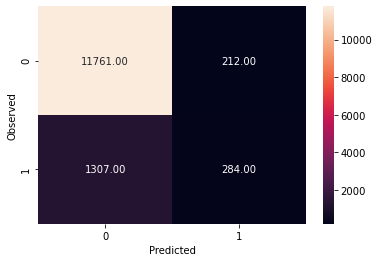

None

Recall: 0.17850408548082966

Precision: 0.5725806451612904

F1 Score: 0.2721609966459032

Roc Auc Score: 0.5803987895874875


In [73]:
print("Trainig accuracy",model.score(x_train,y_train))  
print()
print("Testing accuracy",model.score(x_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_predict))

In [74]:
#The scores are poor, especially Recall, we shall see if we can improve

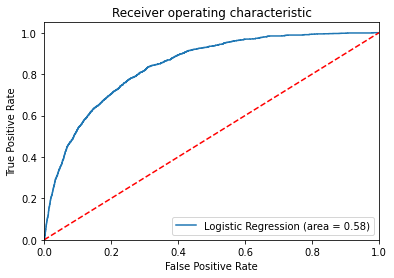

In [75]:
# !pip install yellowbrick

# Additional

#AUC ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [76]:
# Checking Parameters of logistic regression
model.get_params()

#If we dont specify the parameters in the model it takes default value

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 7,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [77]:
# Running a loop to check different values of 'solver'
# all solver can be used with l2, only 'liblinear' and 'saga' works with both 'l1' and 'l2'

train_score=[]
test_score=[]
solver = ['newton-cg','lbfgs','liblinear','sag','saga']
for i in solver:
    model = LogisticRegression(random_state=42,penalty='l2', C = 0.75,solver=i)  # changing values of solver
    model.fit(x_train, y_train) 
    y_predict = model.predict(x_test)     
    train_score.append(round(model.score(x_train, y_train),3))
    test_score.append(round(model.score(x_test, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

[0.896, 0.89, 0.895, 0.883, 0.883]

[0.894, 0.888, 0.893, 0.883, 0.882]


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [78]:
train_score=[]
test_score=[]
solver = ['liblinear','saga']   # changing values of solver which works with 'l1'
for i in solver:
    model = LogisticRegression(random_state=42,penalty='l1', C = 0.75,solver=i)  #changed penalty to 'l1'
    model.fit(x_train, y_train) 
    y_predict = model.predict(x_test)     
    train_score.append(round(model.score(x_train, y_train),3))
    test_score.append(round(model.score(x_test, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['liblinear', 'saga']

[0.895, 0.883]

[0.894, 0.882]


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [79]:
#Highest testing and training accuracy seem to be given by newtom-cg l2 combination so let us use that

In [80]:
model = LogisticRegression(random_state=42,penalty='l2',solver='newton-cg') 
# no class wight added (default None), as adding class weight = balanced is actually reducing the score
model.fit(x_train, y_train) 

y_predict = model.predict(x_test)     

print("Trainig accuracy",model.score(x_train,y_train))  
print()
print("Testing accuracy",model.score(x_test, y_test))

Trainig accuracy 0.8955351218124941

Testing accuracy 0.8934680035387791


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [81]:
# Running a loop to check different values of 'C'

train_score=[]                                 
test_score=[]
C = [0.01,0.1,0.25,0.5,0.75,1]
for i in C:
    model = LogisticRegression(random_state=42,penalty='l2', solver='newton-cg', C=i)  # changing values of C
    model.fit(x_train, y_train) 
    y_predict = model.predict(x_test)     
    train_score.append(round(model.score(x_train,y_train),3)) # appending training accuracy in a blank list for every run of the loop
    test_score.append(round(model.score(x_test, y_test),3))   # appending testing accuracy in a blank list for every run of the loop
    
print(C)
print()
print(train_score)
print()
print(test_score)

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to co

[0.01, 0.1, 0.25, 0.5, 0.75, 1]

[0.893, 0.895, 0.895, 0.896, 0.896, 0.896]

[0.891, 0.894, 0.894, 0.894, 0.894, 0.893]


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [82]:
#Final model
#c=0.75 and 1 shows highest testing score, so will go with 0.75, also weight should be default (not balanced)
model = LogisticRegression(random_state=42,penalty='l2', solver='newton-cg', C=0.75) 
model.fit(x_train, y_train) 
y_predict = model.predict(x_test)

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


Trainig accuracy 0.8955983189559832

Testing accuracy 0.8935417281038042

Confusion Matrix


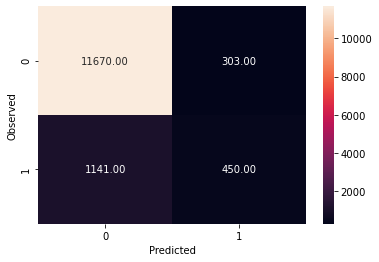

None

Recall: 0.28284098051539913

Precision: 0.5976095617529881

F1 Score: 0.3839590443686007

Roc Auc Score: 0.6287670199495061


In [83]:
print("Trainig accuracy",model.score(x_train,y_train))  
print()
print("Testing accuracy",model.score(x_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_predict))

Notice that this model is improved upon earlier one with higher Recall, but still the scores are very poor. In a way
this reflects bad quality of input data and that's why logistic regression is not suitable

# Decision Tree

In [84]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

In [85]:
print(dTree.score(x_train, y_train))
print(dTree.score(x_test, y_test))


1.0
0.8680330286051312


In [86]:
model_entropy = DecisionTreeClassifier(criterion='entropy')

In [87]:
model_entropy.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [88]:
print("Train: %.2f" % model_entropy.score(x_train, y_train))  # performance on train data
print("Test: %.2f" % model_entropy.score(x_test, y_test))  # performance on test data

Train: 1.00
Test: 0.87


In [89]:
#We shall go ahead with entropy model as it is giving slightlu higher test score.
#The training score is perfect because there is no pruning and it is overfit
#We shall now apply pruning by selecting optimum max depth that can give us better test score and also
#closer alignment in train and test

In [90]:
train_score=[]
test_score=[]
depth = [1,2,3,4,5,6,7,8,9,10]
for i in depth:
    clf_pruned = DecisionTreeClassifier(criterion = "entropy", max_depth=i, random_state=22) 
    clf_pruned.fit(x_train, y_train)
    train_score.append(round(clf_pruned.score(x_train, y_train),3))
    test_score.append(round(clf_pruned.score(x_test, y_test),3))
    
print(depth)
print()
print(train_score)
print()
print(test_score)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

[0.883, 0.885, 0.89, 0.89, 0.893, 0.899, 0.904, 0.907, 0.912, 0.918]

[0.883, 0.882, 0.888, 0.888, 0.889, 0.891, 0.893, 0.892, 0.892, 0.893]


In [91]:
#picking depth = 5
clf_pruned = DecisionTreeClassifier(criterion = "entropy", max_depth=5)
clf_pruned.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [92]:
print("Train: %.3f" % clf_pruned.score(x_train, y_train))  # performance on train data
print("Test: %.3f" % clf_pruned.score(x_test, y_test))  # performance on test data

Train: 0.893
Test: 0.889


In [93]:
y_train.value_counts()

0    27949
1     3698
Name: Target, dtype: int64

In [94]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
#import graphviz

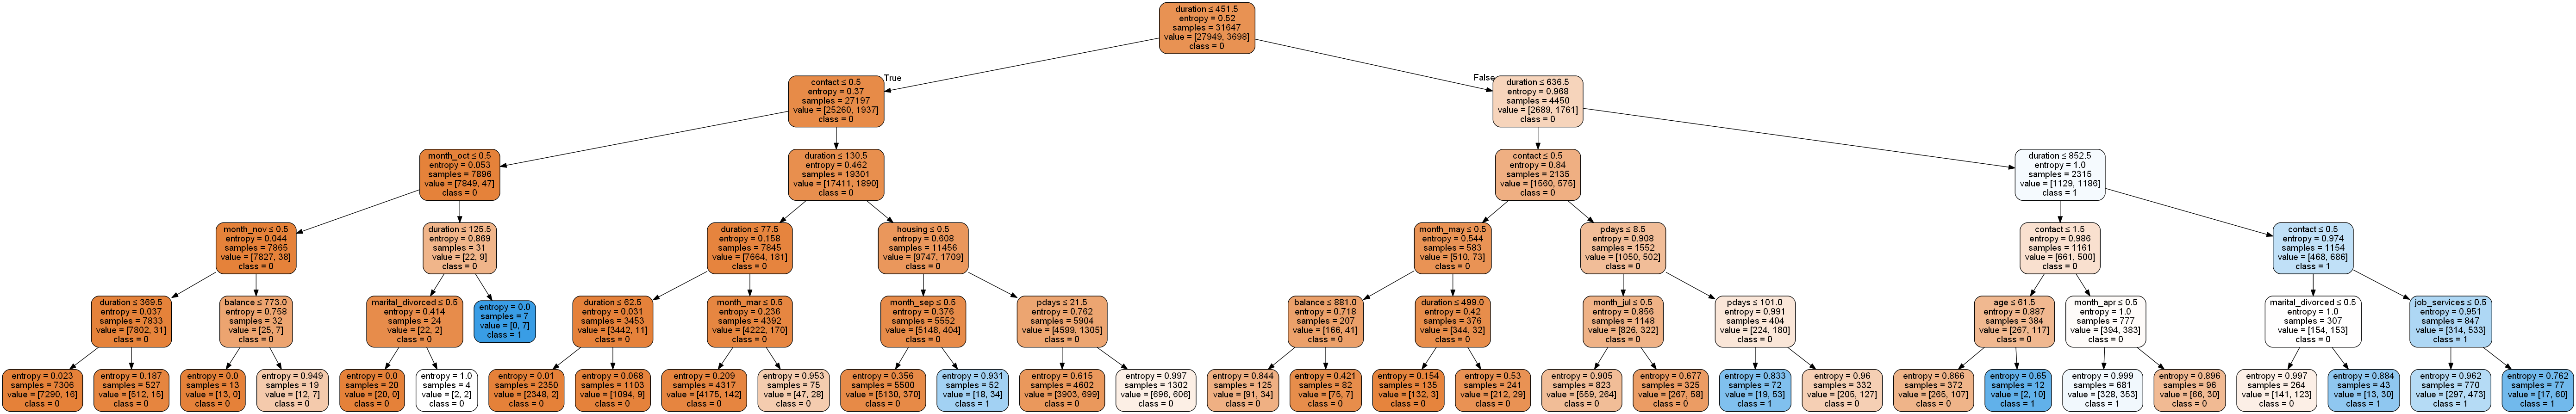

In [95]:
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('termdeposit_pruned.png')
Image(graph.create_png())

In [96]:
#(pd.DataFrame(model_entropy.feature_importances_, columns = ["Imp"], index = x_train.columns))


In [97]:
preds_train = clf_pruned.predict(x_train)
preds_test = clf_pruned.predict(x_test)

acc_DT = accuracy_score(y_test, preds_test)
rec_DT = recall_score(y_test, preds_test)
pre_DT = precision_score(y_test, preds_test)

In [98]:
# Confusion matrix
pd.crosstab(y_test, preds_test, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,11647,326
1,1175,416


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


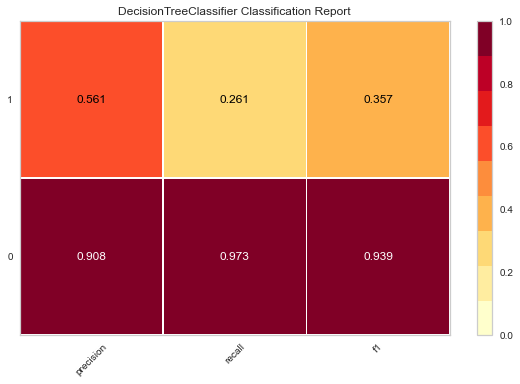

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


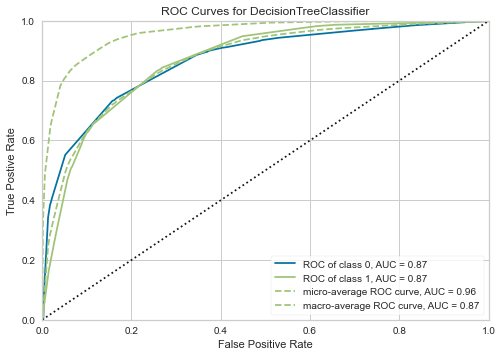

In [99]:
# Visualize model performance with yellowbrick library
from yellowbrick.classifier import ClassificationReport, ROCAUC

viz = ClassificationReport(DecisionTreeClassifier(criterion = "entropy", max_depth=5))
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

roc = ROCAUC(DecisionTreeClassifier(criterion = "entropy", max_depth=5))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
roc.show()

In [100]:
pdata_model['ProbTarget_0'] = clf_pruned.predict_proba(pdata_model[features])[:,0]
pdata_model['ProbTarget_1'] = clf_pruned.predict_proba(pdata_model[features])[:,1]
pdata_model.head()

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,ProbTarget_0,ProbTarget_1
0,58,3,1,2143,0,1,0,261,1,-1,...,0,0,0,0,1,0,0,0,0.99781,0.00219
1,44,2,1,29,0,1,0,151,1,-1,...,0,0,0,0,1,0,0,0,0.99781,0.00219
2,33,2,1,2,0,0,0,76,1,-1,...,0,0,0,0,1,0,0,0,0.99781,0.00219
3,47,2,1,1506,0,1,0,92,1,-1,...,0,0,0,0,1,0,0,0,0.99781,0.00219
4,33,2,1,1,1,1,0,198,1,-1,...,0,0,0,0,1,0,0,0,0.99781,0.00219


In [101]:
## Calculating feature importance

feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)


feat_imp_dict = dict(zip(features, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)

,0
duration,0.622573
contact,0.163675
pdays,0.081848
housing,0.072851
month_sep,0.016299
month_mar,0.012724
month_oct,0.007975
month_nov,0.005968
month_jul,0.003475
balance,0.002875


In [102]:
#The above shows that duration, contact and pdays appear to be top 3 significant

In [103]:
#Store the accuracy, recall, precision results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT, 'recall': rec_DT, 'precision': pre_DT})
resultsDf = resultsDf[['Method', 'accuracy', 'recall', 'precision']]
resultsDf

,Method,accuracy,recall,precision
0,Decision Tree,0.889339,0.261471,0.560647


# Ensemble Models

In [104]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#rfcl = RandomForestClassifier(n_estimators = 50)
#rfcl = rfcl.fit(x_train, y_train)

In [105]:
#Let us select the best estimator number from the below set (50 is most common) based on highest recall value
test_score=[]
rec_score=[]
estimators = [40,50,60,70,80]
for i in estimators:
    rfcl = RandomForestClassifier(n_estimators = i, random_state = 22)
    rfcl = rfcl.fit(x_train, y_train)
    pred_RF = rfcl.predict(x_test)
    acc_RF = accuracy_score(y_test, pred_RF)
    rec_RF = recall_score(y_test, pred_RF)
    test_score.append(round(acc_RF,3))
    rec_score.append(round(rec_RF,3))
print(estimators)
print()
print(test_score)
print()
print(rec_score)

[40, 50, 60, 70, 80]

[0.901, 0.902, 0.902, 0.902, 0.903]

[0.382, 0.39, 0.393, 0.398, 0.404]


In [106]:
#pick 80
rfcl = RandomForestClassifier(n_estimators = 80, random_state = 22)
rfcl = rfcl.fit(x_train, y_train)

In [107]:
pred_RF = rfcl.predict(x_test)
acc_RF = accuracy_score(y_test, pred_RF)
rec_RF = recall_score(y_test, pred_RF)
pre_RF = precision_score(y_test, pred_RF)

In [108]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF], 'recall': [rec_RF], 'precision': [pre_RF]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall', 'precision']]
resultsDf

,Method,accuracy,recall,precision
0,Decision Tree,0.889339,0.261471,0.560647
0,Random Forest,0.902684,0.404148,0.633498


In [109]:
#type(acc_RF)


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


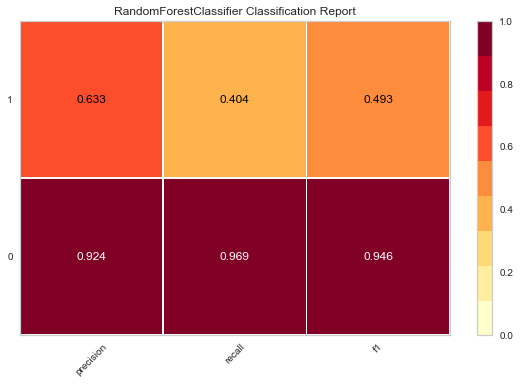

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


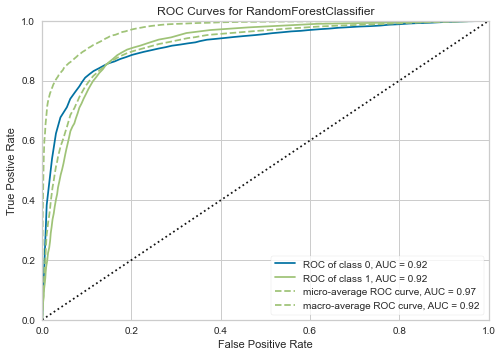

In [110]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(RandomForestClassifier(n_estimators = 80, random_state=22))
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

roc = ROCAUC(RandomForestClassifier(n_estimators = 80, random_state=22))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
roc.show()

In [111]:
#Adaboost
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(x_train, y_train)

In [112]:
pred_AB =abcl.predict(x_test)
acc_AB = accuracy_score(y_test, pred_AB)
rec_AB = recall_score(y_test, pred_AB)
pre_AB = precision_score(y_test, pred_AB)

In [113]:
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_AB], 'recall' : [rec_AB], 'precision' : [pre_AB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall', 'precision']]
resultsDf

,Method,accuracy,recall,precision
0,Decision Tree,0.889339,0.261471,0.560647
0,Random Forest,0.902684,0.404148,0.633498
0,Adaboost,0.888234,0.165305,0.583149


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


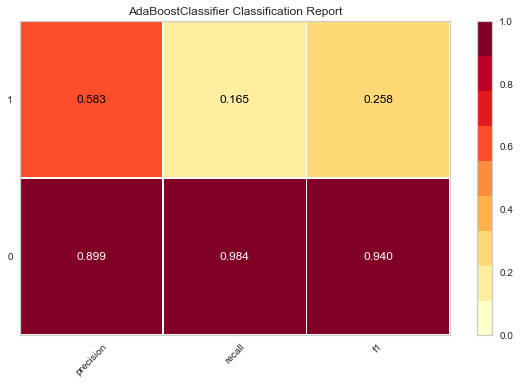

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


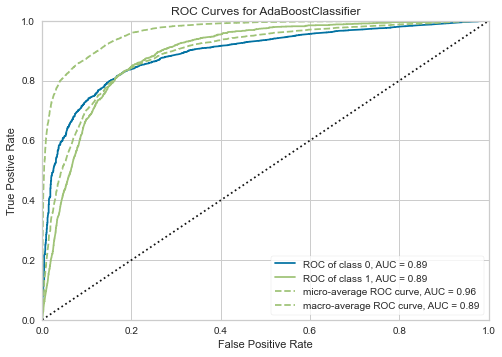

In [114]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

roc = ROCAUC(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
roc.show()

In [115]:
#Adaboost scres, especially Recall, look vary poor so is not suitable

In [116]:
#Bagging classifier
from sklearn.ensemble import BaggingClassifier

#bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
#bgcl = bgcl.fit(x_train, y_train)

In [117]:
#Let us pick up the best value for estimator based on what can give highest Recall
test_score=[]
rec_score=[]
estimators = [40,50,60,70,80]
for i in estimators:
    bgcl = BaggingClassifier(n_estimators=i, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
    bgcl = bgcl.fit(x_train, y_train)
    pred_BG = bgcl.predict(x_test)
    acc_BG = accuracy_score(y_test, pred_BG)
    rec_BG = recall_score(y_test, pred_BG)
    test_score.append(round(acc_BG,3))
    rec_score.append(round(rec_BG,3))
print(estimators)
print()
print(test_score)
print()
print(rec_score)

[40, 50, 60, 70, 80]

[0.902, 0.901, 0.902, 0.902, 0.902]

[0.443, 0.455, 0.455, 0.453, 0.459]


In [118]:
#picking up 80 which is the last one run
pred_BG = bgcl.predict(x_test)
acc_BG = accuracy_score(y_test, pred_BG)
rec_BG = recall_score(y_test, pred_BG)
pre_BG = precision_score(y_test, pred_BG)

In [119]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG], 'recall' : [rec_BG], 'precision': [pre_BG]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall', 'precision']]
resultsDf

,Method,accuracy,recall,precision
0,Decision Tree,0.889339,0.261471,0.560647
0,Random Forest,0.902684,0.404148,0.633498
0,Adaboost,0.888234,0.165305,0.583149
0,Bagging,0.902241,0.458831,0.610879


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


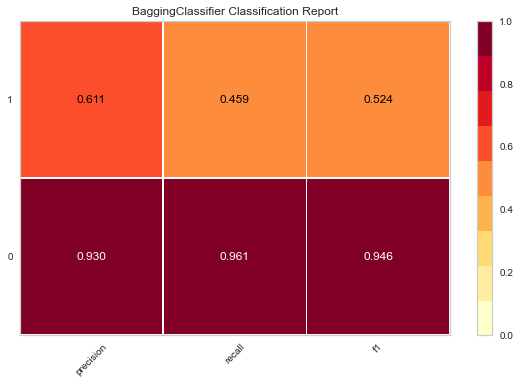

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


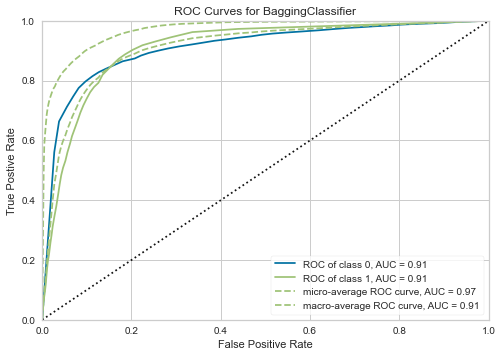

In [120]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(BaggingClassifier(n_estimators=80, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

roc = ROCAUC(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
roc.show()

In [121]:
#Gradient boost
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(x_train, y_train)

In [122]:
pred_GB = gbcl.predict(x_test)
acc_GB = accuracy_score(y_test, pred_GB)
rec_GB = recall_score(y_test, pred_GB)
pre_GB = precision_score(y_test, pred_GB)

In [123]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB], 'recall':[rec_GB], 'precision':[pre_GB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall', 'precision']]
resultsDf

,Method,accuracy,recall,precision
0,Decision Tree,0.889339,0.261471,0.560647
0,Random Forest,0.902684,0.404148,0.633498
0,Adaboost,0.888234,0.165305,0.583149
0,Bagging,0.902241,0.458831,0.610879
0,Gradient Boost,0.897302,0.310497,0.625316


C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


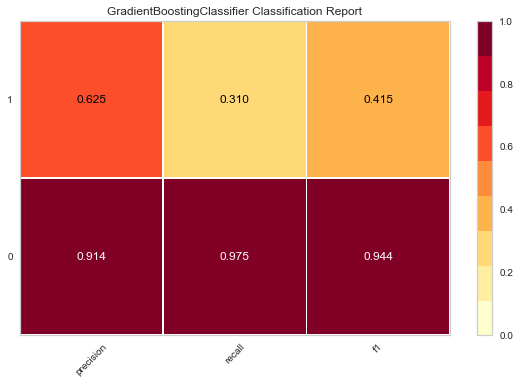

C:\Users\ddaml\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


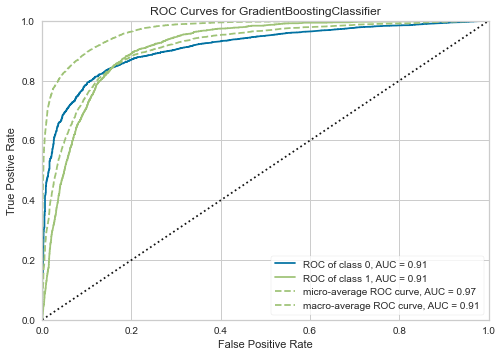

In [124]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

roc = ROCAUC(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
roc.show()

# Conclusion and final model

This dataset had lots of bad data, which made logistic regression unsuitable

Ensemble techniques clearly gave much better results

Within ES, from the results dataframe, we can see that random forest and bagging gave the best results whereas gradient boost
gave slightly better result than LR and DT. Adaboost was very poor

Between bagging and RF , I have chosen bagging because slightly higher Recall value, which is the most business significant score,
and also slightly higher class 1 F1 score (0.52 for BG against 0.49 for RF)
Given below are the scores and confusion matrix with bext model

In [125]:
bgcl = BaggingClassifier(n_estimators=80, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(x_train, y_train)
pred_BG = bgcl.predict(x_test)
acc_BG = accuracy_score(y_test, pred_BG)
rec_BG = recall_score(y_test, pred_BG)
pre_BG = precision_score(y_test, pred_BG)
print(acc_BG, rec_BG, pre_BG)

0.902241226776762 0.45883092394720304 0.6108786610878661


In [126]:
#We had already calculated class 1 ROC score of 0.91 and F1 score of 0.52
# Final Confusion matrix
pd.crosstab(y_test, pred_BG, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,11508,465
1,861,730
